In [29]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [30]:
train = pd.read_csv(r'../input/jobathon-may-2021-credit-card-lead-prediction/train.csv')
test = pd.read_csv(r'../input/jobathon-may-2021-credit-card-lead-prediction/test.csv')

In [31]:
train.shape, test.shape

((245725, 11), (105312, 10))

In [32]:
train['source'] = 'train'
test['source'] = 'test'
data = pd.concat([train,test],ignore_index=True)

In [33]:
data.shape

(351037, 12)

In [34]:
data.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,source
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0.0,train
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0.0,train
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0.0,train
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0.0,train
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0.0,train


In [35]:
data.isnull().sum()

ID                          0
Gender                      0
Age                         0
Region_Code                 0
Occupation                  0
Channel_Code                0
Vintage                     0
Credit_Product          41847
Avg_Account_Balance         0
Is_Active                   0
Is_Lead                105312
source                      0
dtype: int64

In [36]:
data.dtypes

ID                      object
Gender                  object
Age                      int64
Region_Code             object
Occupation              object
Channel_Code            object
Vintage                  int64
Credit_Product          object
Avg_Account_Balance      int64
Is_Active               object
Is_Lead                float64
source                  object
dtype: object

In [37]:
data.nunique()

ID                     351037
Gender                      2
Age                        63
Region_Code                35
Occupation                  4
Channel_Code                4
Vintage                    66
Credit_Product              2
Avg_Account_Balance    162137
Is_Active                   2
Is_Lead                     2
source                      2
dtype: int64

In [38]:
data['Credit_Product'].value_counts()

No     205965
Yes    103225
Name: Credit_Product, dtype: int64

In [39]:
data['Credit_Product'].replace(np.nan,'Unknow',inplace=True)

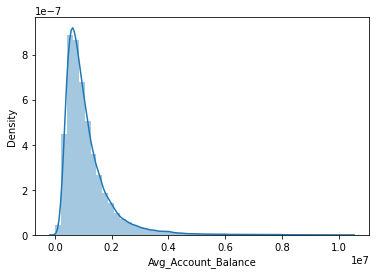

In [40]:
sns.distplot(data['Avg_Account_Balance'])
plt.show()

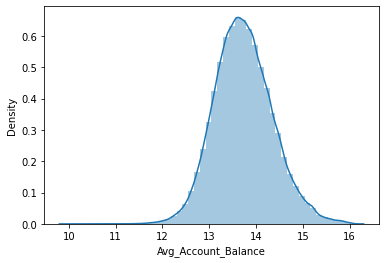

In [41]:
data['Avg_Account_Balance'] = np.log(data['Avg_Account_Balance'])
sns.distplot(data['Avg_Account_Balance'])
plt.show()

In [42]:
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

#Drop unnecessary columns:
test.drop(['Is_Lead','source'],axis=1,inplace=True)
train.drop('source',axis=1,inplace=True)

In [43]:
train.drop('ID',axis=1,inplace=True)
test.drop("ID",axis=1,inplace = True)

In [44]:
train.dtypes

Gender                  object
Age                      int64
Region_Code             object
Occupation              object
Channel_Code            object
Vintage                  int64
Credit_Product          object
Avg_Account_Balance    float64
Is_Active               object
Is_Lead                float64
dtype: object

In [45]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
var_mod = ['Gender','Region_Code','Occupation','Channel_Code','Credit_Product','Is_Active']
for i in var_mod:
    train[i] = le.fit_transform(train[i])
    test[i] = le.fit_transform(test[i])

In [46]:
X = train.drop('Is_Lead',axis=1)
y = train['Is_Lead']

In [64]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

def cross_val(X, y, model,params,folds=5):

    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=21)
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f"Fold: {fold}")
        x_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        x_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        alg = model(**params)
        alg.fit(x_train, y_train,
                eval_set=[(x_test, y_test)],
                early_stopping_rounds=100,
                verbose=400)

        pred = alg.predict_proba(x_test)[:, 1]
        roc_score = roc_auc_score(y_test, pred)
        print(f"roc_auc_score: {roc_score}")
        print("-"*50)
    
    return alg

In [70]:
lgb_params= {'learning_rate': 0.045, 
             'n_estimators': 20000, 
             'max_bin': 94,
             'num_leaves': 10, 
             'max_depth': 27, 
             'reg_alpha': 8.457, 
             'reg_lambda': 6.853, 
             'subsample': 0.749}

In [71]:
from lightgbm import LGBMClassifier
lgb_model = cross_val(X, y, LGBMClassifier, lgb_params)

Fold: 0
Training until validation scores don't improve for 100 rounds
[400]	valid_0's binary_logloss: 0.344957
Early stopping, best iteration is:
[606]	valid_0's binary_logloss: 0.344761
roc_auc_score: 0.8739591361981252
--------------------------------------------------
Fold: 1
Training until validation scores don't improve for 100 rounds
[400]	valid_0's binary_logloss: 0.345185
Early stopping, best iteration is:
[536]	valid_0's binary_logloss: 0.345101
roc_auc_score: 0.87189049333395
--------------------------------------------------
Fold: 2
Training until validation scores don't improve for 100 rounds
[400]	valid_0's binary_logloss: 0.343321
[800]	valid_0's binary_logloss: 0.343172
Early stopping, best iteration is:
[772]	valid_0's binary_logloss: 0.343165
roc_auc_score: 0.8751797014570244
--------------------------------------------------
Fold: 3
Training until validation scores don't improve for 100 rounds
[400]	valid_0's binary_logloss: 0.342009
[800]	valid_0's binary_logloss: 0.

In [65]:
cat_params= {'n_estimators': 20000, 
                  'depth': 4, 
                  'learning_rate': 0.023, 
                  'colsample_bylevel': 0.655, 
                  'bagging_temperature': 0.921, 
                  'l2_leaf_reg': 10.133}

In [66]:
from catboost import CatBoostClassifier
cat_model = cross_val(X, y, CatBoostClassifier, cat_params)

Fold: 0
0:	learn: 0.6745542	test: 0.6745294	best: 0.6745294 (0)	total: 67.9ms	remaining: 22m 37s
400:	learn: 0.3452302	test: 0.3473096	best: 0.3473096 (400)	total: 25.4s	remaining: 20m 40s
800:	learn: 0.3430042	test: 0.3458509	best: 0.3458490 (794)	total: 50.1s	remaining: 19m 59s
1200:	learn: 0.3418834	test: 0.3456426	best: 0.3456355 (1152)	total: 1m 15s	remaining: 19m 47s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3455901552
bestIteration = 1334

Shrink model to first 1335 iterations.
roc_auc_score: 0.8733336179115447
--------------------------------------------------
Fold: 1
0:	learn: 0.6744893	test: 0.6744524	best: 0.6744524 (0)	total: 138ms	remaining: 46m 6s
400:	learn: 0.3453531	test: 0.3474454	best: 0.3474454 (400)	total: 25.3s	remaining: 20m 38s
800:	learn: 0.3431069	test: 0.3459449	best: 0.3459449 (800)	total: 50.1s	remaining: 19m 59s
1200:	learn: 0.3419862	test: 0.3456246	best: 0.3456233 (1198)	total: 1m 15s	remaining: 19m 35s
1600:	learn: 0.3410629	t

In [72]:
pred_test_lgb = lgb_model.predict_proba(test)[:,1]

In [67]:
pred_test_cat = cat_model.predict_proba(test)[:,1]

In [75]:
sample_submission = pd.read_csv(r'../input/jobathon-may-2021-credit-card-lead-prediction/sample_submission.csv')

In [76]:
sample_submission['Is_Lead'] = pred_test_lgb
sample_submission.to_csv(f'submission.csv',index=False)

In [ ]:
sample_submission